# infos

In [1]:
# Charger le modèle. Chaque chapitre qui suivra est indépendant des autres


# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'

# Dimensions des images
img_dim = (224,224)
img_shape = (224,224,3)

##### Reste à faire :
- Compléter la partie évaluation modèle (courbes, rapport de classification, ..)
- Créer la partie GradCam

# Librairies à charger

In [2]:
# Librairies servant à charger le modèle
from tensorflow import keras

# Librairies servant à charger les données
import pandas as pd


# Librairies servant à charger les images et les afficher
import requests
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Librairies servant à l'interprétabilité du modèle
from IPython.display import Image, display
import matplotlib.cm as cm
%matplotlib inline

# Fonctions

In [3]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon=0.1):
    '''Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original

        '''
    
    
    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")




    return df, df_ech

# Chargement du DF

In [4]:
df, df_ech = import_df(chemin_images, chemin_csv)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


In [5]:
nom_classes = {
    0: "Agaricales",
    1: "Agaricus",
    2: "Amanita",
    3: "Cortinarius",
    4: "Entoloma",
    5: "Inocybe",
    6: "Mycena",
    7: "Polyporales",
    8: "Psathyrella",
    9: "Russula"
}

# Chargement du modèle

In [6]:
nom_model = '../model/gpot_v01_full'
model = keras.models.load_model(nom_model)

# Evaluation du modèle

In [ ]:
# MAtrice de confusion
# Rapport de classification

# Chargement des images

### Image du dataset

In [7]:
# Chargement aléatoire d'une image
random_image_row = df.sample(n=1)  # Selection d'une ligne au hasard dans le df
img_path = random_image_row['image_url'].values[0]  # Génère le chemin correspondant à l'image aléaotire

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

### Image d'internet

In [8]:
url = 'https://www.hautesavoiephotos.com/champis/russula-aurea.jpg'

response = requests.get(url)
if response.status_code == 200:
    image_data = response.content
    img_web = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    img_web = cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB)

    w = image.img_to_array(img_web)
    w = np.expand_dims(w, axis=0)
    w = preprocess_input(w)

else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

# Predictions

In [9]:
# Faites une prédiction avec le modèle sur l'image chargée
predictions = model.predict(x)
index_classe_predite = np.argmax(predictions)
nom_classe_predite = nom_classes[index_classe_predite]

predictions_web = model.predict(w)
index_classe_web = np.argmax(predictions_web)
nom_classe_predite = nom_classes[index_classe_web]

1/1 [==============================] - 1s 851ms/step


### Prediction image dataset

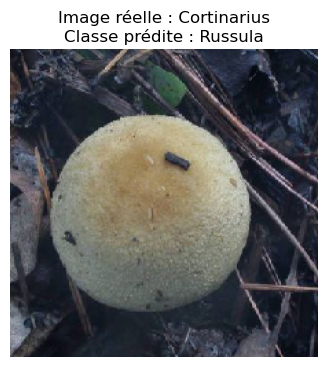

In [10]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Image réelle : {image_label}\nClasse prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

### Prediction image Web

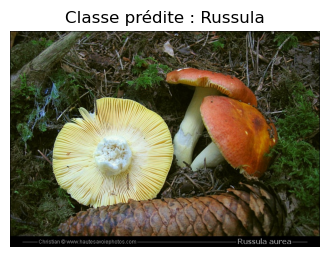

In [11]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img_web)
plt.title(f'Classe prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

## Interprétabilité (Grad Cam)

### Fonctions pour Grad Cam

In [ ]:
pre_train_model = tf.keras.applications.ResNet50V2(weights='imagenet')
layer_names = [layer.name for layer in pre_train_model.layers]
last_conv_layer_name = None


for layer_name in reversed(layer_names):
    if 'conv' in layer_name:
        last_conv_layer_name = layer_name
        break

last_conv_layer = pre_train_model.get_layer(last_conv_layer_name)


### Grad Cam